In [47]:
import numpy as np
import patsy
from scipy.integrate import quad
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import minimize
from findpeaks import findpeaks
from quadprog import solve_qp

In [2]:
from module.auto_peak_valley import Peak_Valley_Simu, IsotonicReg, constrained_splines_reg, comprehensive_csr
from module.knot_func import *

### 模擬用的函式 $ \frac{3}{\pi}(sin(6\pi x) + \frac{sin(14\pi x)}{2}) $

In [3]:
def f(x):
    return 3*(np.sin(6*np.pi*x) + np.sin(14*np.pi*x)/2) / np.pi

In [4]:
np.random.seed(42)
x = np.linspace(0, 1, 1000).round(5)
y = f(x) + np.random.normal(scale=0.3, size=(1000,))

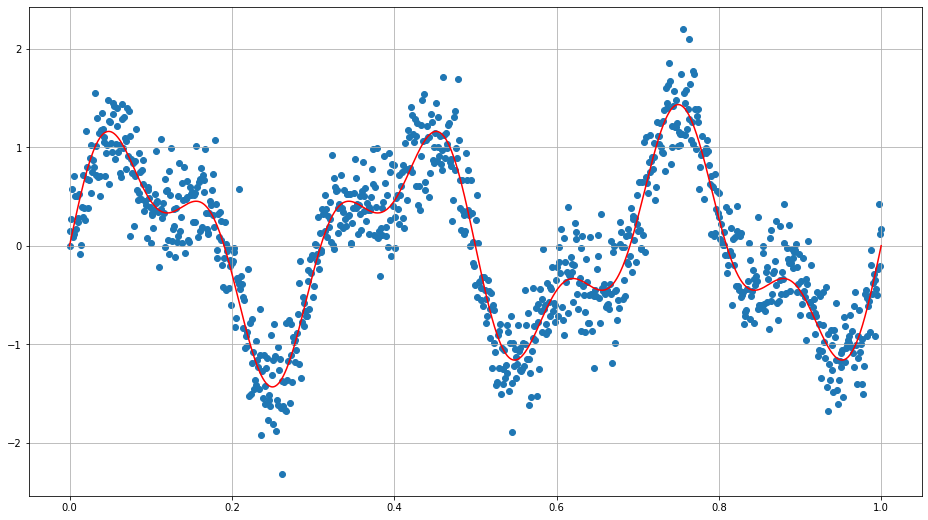

In [5]:
plt.figure(figsize=(16, 9))
plt.scatter(x, y)
plt.plot(x, f(x), c="r")
plt.grid()
plt.show()

### 使用自己的方法找峰谷位置

In [6]:
multi_peak = Peak_Valley_Simu()
multi_peak.x, multi_peak.y = x, y

In [7]:
auto_multi_init_demarcation, auto_multi_peak_detection_result, auto_multi_peak_detection_dict = \
    multi_peak.auto_peak_points_detection_v3(step=0.05, distance=0.07, iter_scale=1)
print("峰座標：", auto_multi_peak_detection_result)
print(auto_multi_init_demarcation)

auto_multi_initvalley_demarcation, auto_multi_valley_detection_result, auto_multi_valley_detection_dict = \
    multi_peak.auto_valley_points_detection(step=0.05, distance=0.1, iter_scale=1)
print("谷座標：", auto_multi_valley_detection_result)
print(auto_multi_initvalley_demarcation)

峰座標： deque([0.05005, 0.45045, 0.74975])
deque([0.05005], maxlen=1)
谷座標： deque([0.25025, 0.54955, 0.94995])
deque([0.25025], maxlen=1)


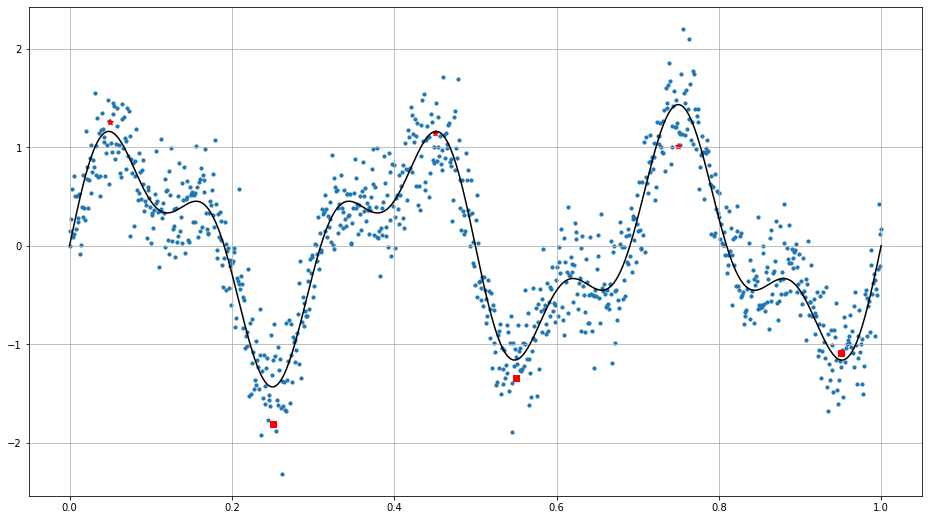

In [8]:
peak_x = list(auto_multi_peak_detection_result)
peak_y = y[[x.tolist().index(i) for i in peak_x]]
valley_x = list(auto_multi_valley_detection_result)
valley_y = y[[x.tolist().index(i) for i in valley_x]]
plt.figure(figsize=(16, 9))
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(peak_x, peak_y, c="r", marker='*')
plt.scatter(valley_x, valley_y, c="r", marker='s')
plt.grid()
plt.show()

In [9]:
def to_softmax_v2(pv_coordinate: list): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_copy = np.array(pv_coordinate)
    output = pv_coordinate_copy / sum(pv_coordinate_copy)
    return output # array

def reverse_softmax_v2(pv_coordinate_softmax_form, x=x): # 搞錯的 multi-class logistic reg 作法
    pv_coordinate_original_form = 0.05005*(1/pv_coordinate_softmax_form[0])*pv_coordinate_softmax_form
    # print(pv_coordinate_original_form)
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

def to_softmax_v3(pv_coordinate, base=0): # 最終版的 multi-class logistic reg 作法
    pv_coordinate_copy = np.hstack((x[0], np.array(pv_coordinate), x[-1]))
    pv_coordinate_copy2 = np.diff(pv_coordinate_copy)
    log_odds = np.log(pv_coordinate_copy2 / pv_coordinate_copy2[base])
    return log_odds

def reverse_softmax_v3(pv_coordinate_softmax_form): # 最終版的 multi-class logistic reg 作法
    # pv_coordinate_original_form = np.exp(pv_coordinate_softmax_form) * 0.24024
    # pv_coordinate_original_form = pv_coordinate_original_form.cumsum()[:-1]
    pv_coordinate_base_form = 1 / np.sum(np.exp(pv_coordinate_softmax_form))
    pv_coordinate_original_form = np.hstack((pv_coordinate_base_form, pv_coordinate_base_form*np.exp(pv_coordinate_softmax_form[1:]))).cumsum()
    pv_coordinate_original_form = pv_coordinate_original_form[:-1]
    nearest_x = [min(x, key=lambda k: abs(k-j)) for j in pv_coordinate_original_form]
    nearest_x_index = [list(x).index(i) for i in nearest_x]
    nearest_x_index = [0] + nearest_x_index + [999]
    return nearest_x_index

In [10]:
pv, pv_index = multi_peak.peak_valley_index()
pv_coordinate_softmax_transform = to_softmax_v3(pv)
print(pv, "\n", pv_index, sep="")

[0.05005, 0.25025, 0.45045, 0.54955, 0.74975, 0.94995]
[0, 50, 250, 450, 549, 749, 949, 999]


RSS:  70.9735170195479


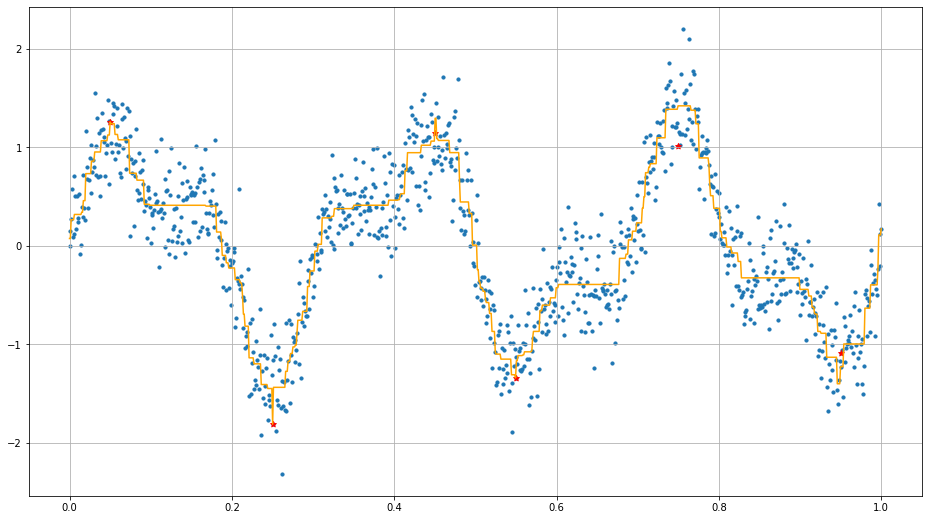

In [11]:
multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=pv_index)
multi_tuned_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg.isotonic_rss())
multi_tuned_pv_isoreg.plot_isoreg()

In [12]:
# minimize_result = minimize(multi_peak.isotonic_reg_rss_v3, pv_coordinate_softmax_transform, method="Nelder-Mead", options={"adaptive": True})
# np.save(".\\weights\\minimize_simulation_x", minimize_result.x)

In [13]:
minimize_result = np.load(".\\weights\\minimize_simulation_x.npy")
minimize_result

array([-1.23155312e-05,  1.40734812e+00,  1.38611606e+00,  6.82769406e-01,
        1.43978889e+00,  1.38620032e+00,  8.87053988e-16])

In [14]:
new_pv = x[reverse_softmax_v3(minimize_result)]
new_pv_index = reverse_softmax_v3(minimize_result)
print(new_pv)
print(new_pv_index)

[0.      0.04905 0.25025 0.44745 0.54555 0.75375 0.95095 1.     ]
[0, 49, 250, 447, 545, 753, 950, 999]


RSS:  70.09720000068351


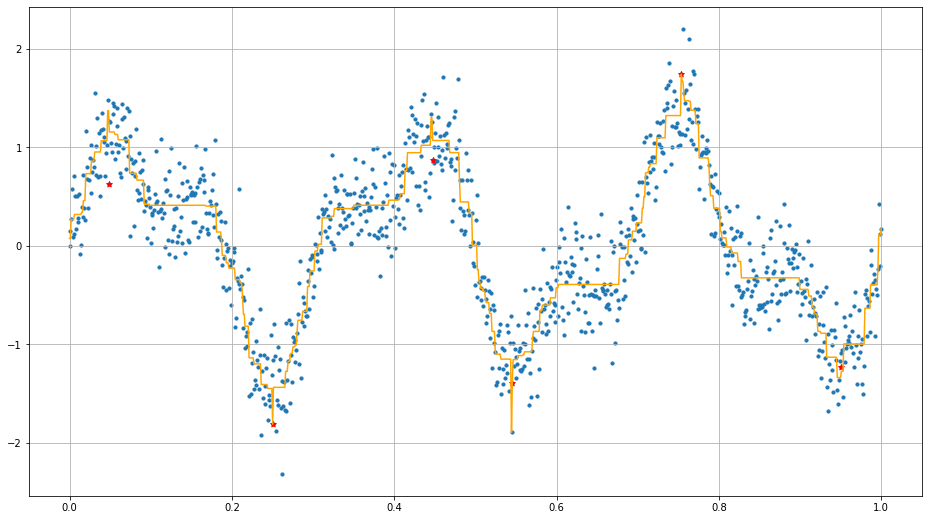

In [15]:
# np.array([0.0483, 0.1204, 0.1559, 0.25, 0.344, 0.3795, 0.4517, 0.5493, 0.6204, 0.6559, 0.75, 0.8441, 0.8796, 0.9517])
# multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=[0, 50, 125, 161, 259, 356, 393, 468, 569, 642, 679, 776, 874, 911, 985, 999])
multi_tuned_pv_isoreg = IsotonicReg(x=x, y=y, pv_index=new_pv_index)
multi_tuned_pv_isoreg.iso_fit_transform()
print("RSS: ", multi_tuned_pv_isoreg.isotonic_rss())
multi_tuned_pv_isoreg.plot_isoreg()

In [16]:
knots = get_knot(x, y)
print(len(knots))

13


In [17]:
compre_csr1 = comprehensive_csr(x=x, y=y, pv_coordinate=new_pv[1:-1], pv_index=new_pv_index, knots_of_each_part=knots)
# compre_csr1 = comprehensive_csr(x=x, y=y, pv_coordinate=pv, pv_index=pv_index, knots_of_each_part=knots)

In [18]:
print(len(compre_csr1.comprehensive_knots()))
print(compre_csr1.comprehensive_knots())

19
[0.04905, 0.04905, 0.11311, 0.17618, 0.25025, 0.25225, 0.32232, 0.38839, 0.44745, 0.46246, 0.53854, 0.54555, 0.60661, 0.67768, 0.75375, 0.75475, 0.82683, 0.94494, 0.95095]


In [19]:
compre_csr1.pv_index_in_compre_knots

[1, 5, 9, 12, 15, 19]

In [20]:
compre_csr1.splineDesign_derivative_func_Matrix(deg=3).shape

(21, 23)

In [21]:
G, a, C, b = compre_csr1.generate_GaCb_matrix(deg=3)
print(G.shape, a.shape, C.shape, b.shape)

(23, 23) (23,) (23, 21) (21,)


In [22]:
solve_qp(G, a, C, b, meq=0)

(array([ 0.20370676,  0.29171117,  1.13852666,  1.13852666, -0.25662853,
         1.22879807, -1.48890241, -1.41883306,  1.15471874, -0.1198351 ,
         1.1492863 ,  1.14179643, -1.1000861 , -1.28097519,  0.23988223,
        -1.14623413,  1.40066574,  1.36695647, -1.64475266,  0.31376639,
        -1.79157765, -0.34244667, -0.100562  ]),
 -558.5372035572925,
 array([ 0.20797836,  0.27665034,  1.15235514,  1.12831968, -0.24972245,
         1.22478759, -1.48803493, -1.41804058,  1.150789  , -0.11323807,
         1.13904305,  1.16566919, -1.13723968, -1.27822912,  0.33333133,
        -1.34214365,  1.66664264,  1.11542453, -1.36564346,  0.18121617,
        -1.71725127, -0.41510914, -0.07856467]),
 array([4, 0]),
 array([0.00363219, 0.        , 0.        , 0.04493446, 0.24228544,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0

In [23]:
y_constrained_result = compre_csr1.fit_constrained_transform(deg=3, meq=0, first_part_increase=True)

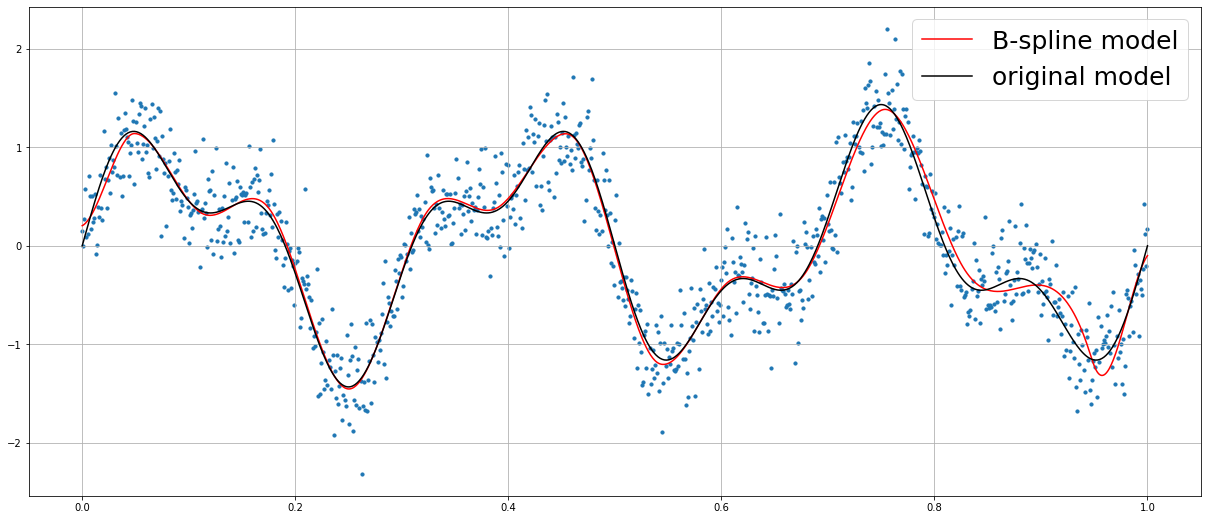

MSE:  0.09003452722713425


In [44]:
plt.figure(figsize=(21,9))
plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result, c="r", label="B-spline model")
plt.plot(x, f(x), c="k", label="original model")
plt.legend(fontsize=25)
plt.grid()
plt.show()
print("MSE: ", ((y_constrained_result.reshape((-1,)) - y)**2).mean())

In [45]:
print("RSS: ", ((y_constrained_result.reshape((-1,)) - f(x))**2).mean())

RSS:  0.006022633725113774


In [48]:
coef1 = compre_csr1.Solve_QP(deg=3)
# print("coef: ", coef1)
knots1 = compre_csr1.comprehensive_knots()
# print("knots1: ", knots1)
def fhat1(w):
    bx = patsy.bs(x=w, knots=knots1, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef1
    return ans
def SE1(w):
    return (fhat1(w) - f(w))**2
ise1, _ = quad(SE1, 0, 1)
print("ISE: ", ise1)

ISE:  0.006001224281764798


### 使用 [Scipy Peak finding](https://scipy.github.io/devdocs/reference/generated/scipy.signal.find_peaks.html#scipy.signal.find_peaks) 方法找峰谷位置

In [25]:
peaks, _ = find_peaks(y, distance=100, prominence=0.5)
valleys, _ = find_peaks(-y, distance=100, prominence=0.5)

In [26]:
pv_index2 = np.hstack((peaks, valleys))
pv_index2.sort()

In [27]:
pv2 = x[pv_index2]
print(pv2)

[0.03103 0.11011 0.17918 0.26226 0.32332 0.38238 0.46046 0.54454 0.61461
 0.64665 0.75576 0.83083 0.88088 0.93393 0.997  ]


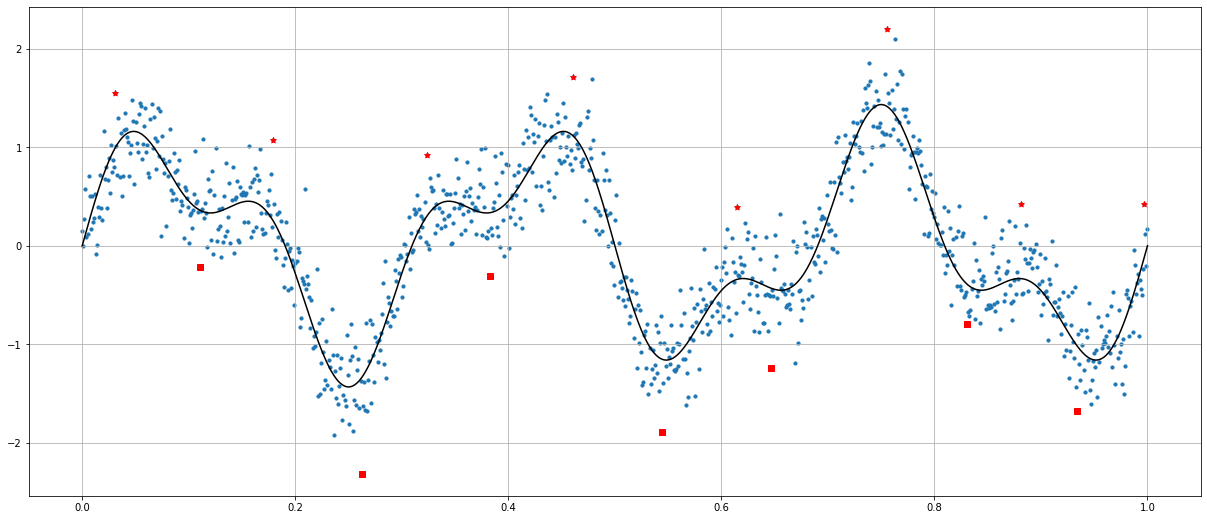

In [43]:
plt.figure(figsize=(21,9))
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[peaks], y[peaks], c="r", marker='*')
plt.scatter(x[valleys], y[valleys], c="r", marker='s')
plt.grid()
plt.show()

In [29]:
compre_csr2 = comprehensive_csr(x=x, y=y, pv_coordinate=pv2, pv_index=pv_index2, knots_of_each_part=knots)

In [30]:
G2, a2, C2, b2 = compre_csr2.generate_GaCb_matrix(deg=3)
# solve_qp(G2, a2, C2, b2, meq=14)

In [31]:
y_constrained_result2 = compre_csr2.fit_constrained_transform(deg=3, meq=14, first_part_increase=True)

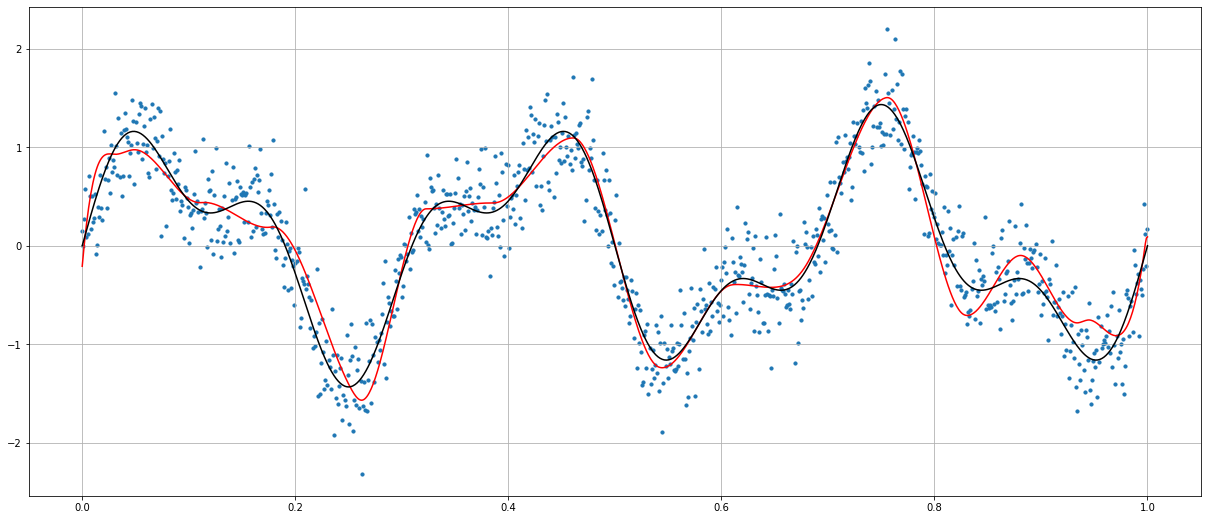

MSE:  0.10328459748590907


In [50]:
plt.figure(figsize=(21,9))
plt.scatter(x, y, s=10)
plt.plot(x, y_constrained_result2, c="r", label="B-spline model")
plt.plot(x, f(x), c="k", label="original model")
plt.grid()
plt.show()
print("MSE: ", ((y_constrained_result2.reshape((-1,)) - y)**2).mean())

In [51]:
print("RSS: ", ((y_constrained_result2.reshape((-1,)) - f(x))**2).mean())

RSS:  0.021696670017720986


In [52]:
coef2 = compre_csr2.Solve_QP(deg=3)
# print("coef: ", coef2)
knots2 = compre_csr2.comprehensive_knots()
# print("knots2: ", knots2)
def fhat2(w):
    bx = patsy.bs(x=w, knots=knots2, degree=3,
                  lower_bound=0, upper_bound=1,
                  include_intercept=True)
    ans = bx @ coef2
    return ans
def SE2(w):
    return (fhat2(w) - f(w))**2
ise2, _ = quad(SE2, 0, 1)
print("ISE: ", ise2)

ISE:  0.012353666665132896


C:\Users\Jater\AppData\Local\Temp/ipykernel_6464/1906287995.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  ise2, _ = quad(SE2, 0, 1)


### 使用 [findpeaks Peakdetect](https://erdogant.github.io/findpeaks/pages/html/Peakdetect.html) 方法找峰谷位置

[findpeaks] >Finding peaks in 1d-vector using [peakdetect] method..


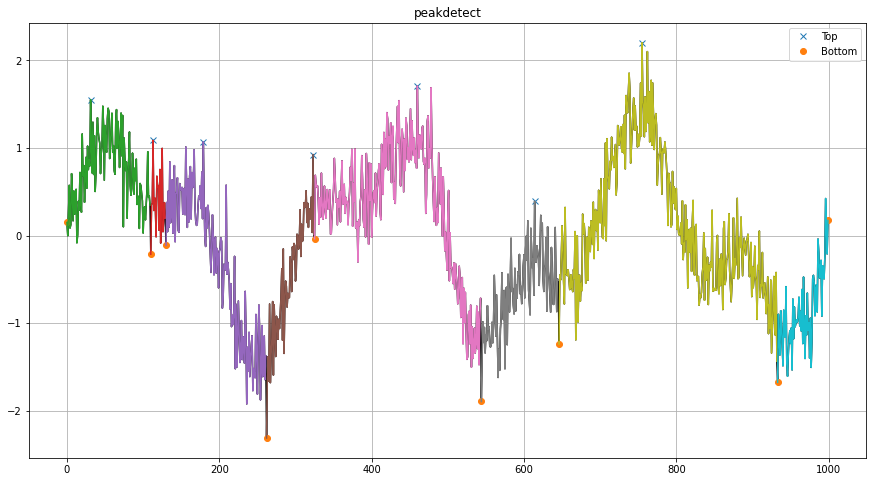

(None, <AxesSubplot:title={'center':'peakdetect'}>)

In [33]:
fp = findpeaks(method='peakdetect', lookahead=50)
fp_result = fp.fit(y)
fp.plot()

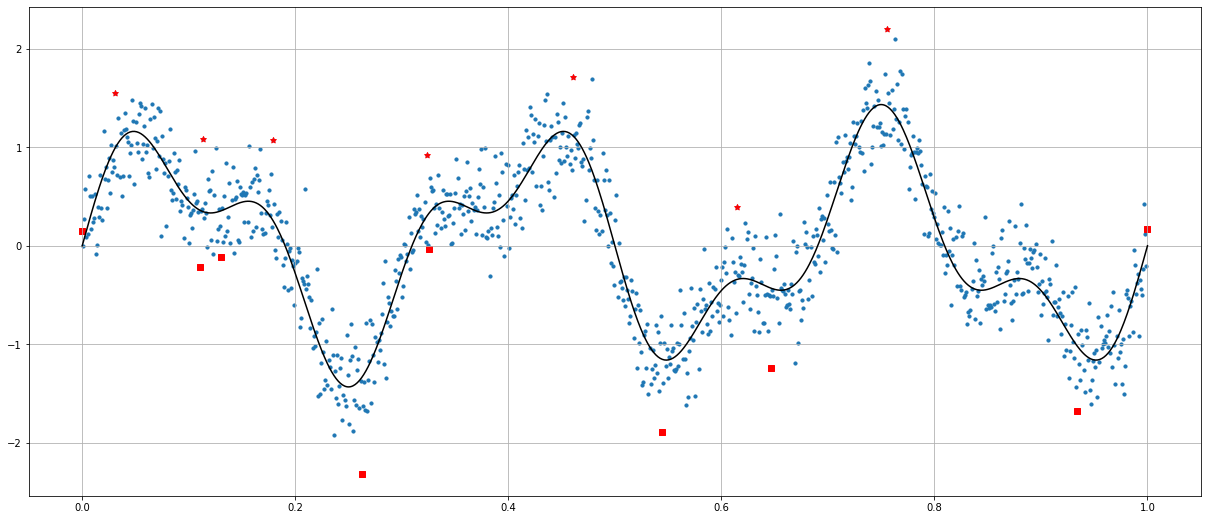

In [34]:
plt.figure(figsize=(21,9))
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[fp_result["df"]["peak"]], y[fp_result["df"]["peak"]], c="r", marker='*')
plt.scatter(x[fp_result["df"]["valley"]], y[fp_result["df"]["valley"]], c="r", marker='s')
plt.grid()
plt.show()

### 使用 [findpeaks Topology](https://erdogant.github.io/findpeaks/pages/html/Topology.html) 方法找峰谷位置

[findpeaks] >Finding peaks in 1d-vector using [topology] method..
[findpeaks] >Detect peaks using topology method with limit at 1.


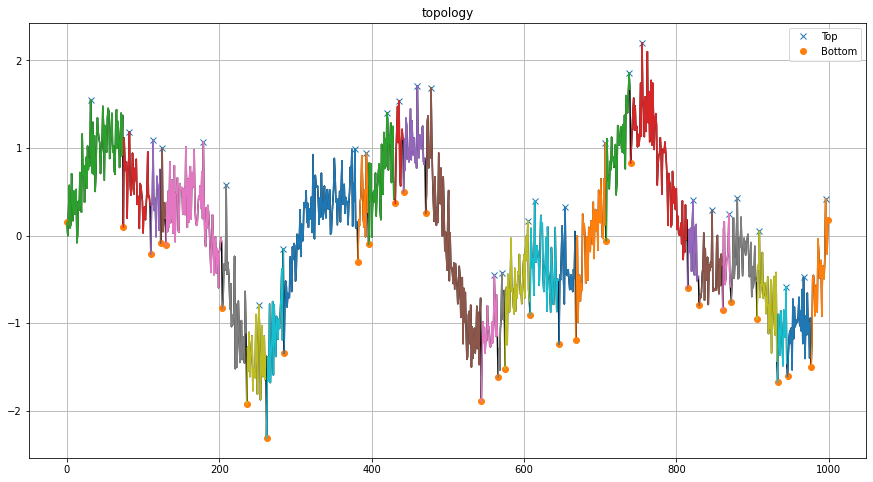

(None, <AxesSubplot:title={'center':'topology'}>)

In [35]:
fp_tp = findpeaks(method='topology', limit=1)
fp_tp_result = fp_tp.fit(y)
fp_tp.plot()

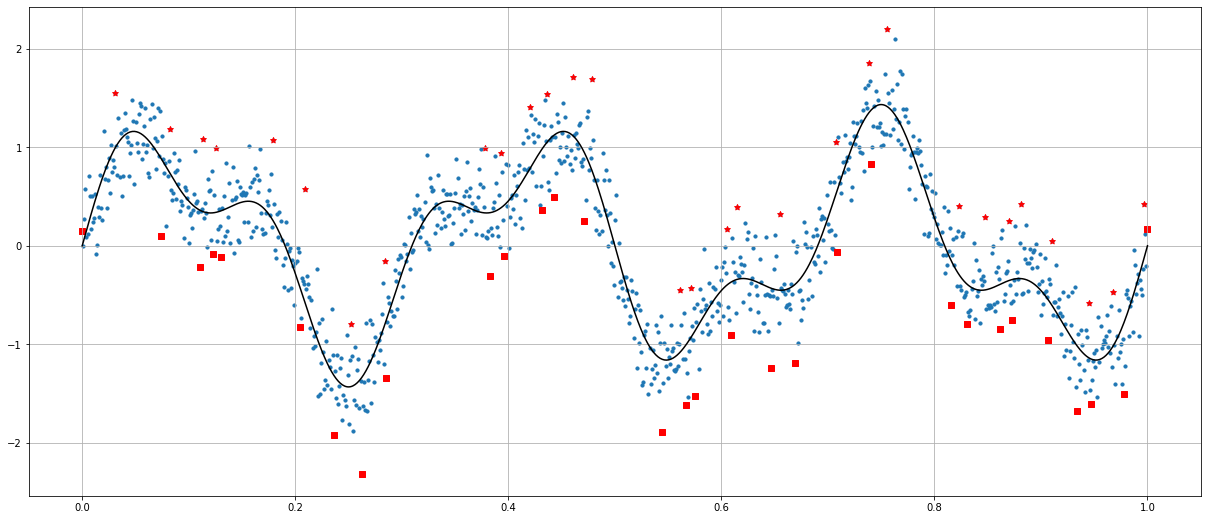

In [36]:
plt.figure(figsize=(21, 9))
plt.scatter(x, y, s=10)
plt.plot(x, f(x), c="k")
plt.scatter(x[fp_tp_result["df"]["peak"]], y[fp_tp_result["df"]["peak"]], c="r", marker='*')
plt.scatter(x[fp_tp_result["df"]["valley"]], y[fp_tp_result["df"]["valley"]], c="r", marker='s')
plt.grid()
plt.show()

In [37]:
pv_index3 = np.arange(1000)[fp_tp_result["df"]["peak"].to_numpy() | fp_tp_result["df"]["valley"].to_numpy()][1:-1]
pv3 = x[pv_index3]
print(pv3, "\n", pv_index3, sep="")

[0.03103 0.07407 0.08208 0.11011 0.11311 0.12312 0.12513 0.13013 0.17918
 0.2042  0.20921 0.23624 0.25225 0.26226 0.28428 0.28529 0.37838 0.38238
 0.39339 0.3964  0.42042 0.43143 0.43644 0.44244 0.46046 0.47147 0.47848
 0.54454 0.56156 0.56657 0.57157 0.57558 0.60561 0.60861 0.61461 0.64665
 0.65465 0.66867 0.70771 0.70871 0.73874 0.74074 0.75576 0.81582 0.82282
 0.83083 0.84785 0.86186 0.86987 0.87287 0.88088 0.90691 0.90991 0.93393
 0.94494 0.94695 0.96797 0.97798 0.997  ]
[ 31  74  82 110 113 123 125 130 179 204 209 236 252 262 284 285 378 382
 393 396 420 431 436 442 460 471 478 544 561 566 571 575 605 608 614 646
 654 668 707 708 738 740 755 815 822 830 847 861 869 872 880 906 909 933
 944 946 967 977 996]


In [38]:
# compre_csr3 = comprehensive_csr(x=x, y=y, pv_coordinate=pv3, pv_index=pv_index3, knots_of_each_part=knots)

In [39]:
# G3, a3, C3, b3 = compre_csr3.generate_GaCb_matrix(deg=3)
# solve_qp(G3, a3, C3, b3, meq=8)

In [40]:
# y_constrained_result3 = compre_csr3.fit_constrained_transform(deg=3, meq=8, first_part_increase=True)

In [41]:
# plt.figure(figsize=(21,9))
# plt.scatter(x, y, s=10)
# plt.plot(x, y_constrained_result3, c="r")
# plt.plot(x, f(x), c="k")
# plt.grid()
# plt.show()